In [78]:
# Introduction to the notebook

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [79]:
# Load the data
data = pd.read_csv('../data/data_daily.csv', parse_dates=['# Date'], index_col='# Date')

# Resample data to monthly totals
monthly_data = data['Receipt_Count'].resample('M').sum()

# Inspect the data
monthly_data.head()


/var/folders/9j/4qhm498x25s5m7dmvf5wny7m0000gn/T/ipykernel_36614/4208638559.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Receipt_Count'].resample('M').sum()


# Date
2021-01-31    236736687
2021-02-28    220033460
2021-03-31    248608625
2021-04-30    250644830
2021-05-31    263151748
Freq: ME, Name: Receipt_Count, dtype: int64

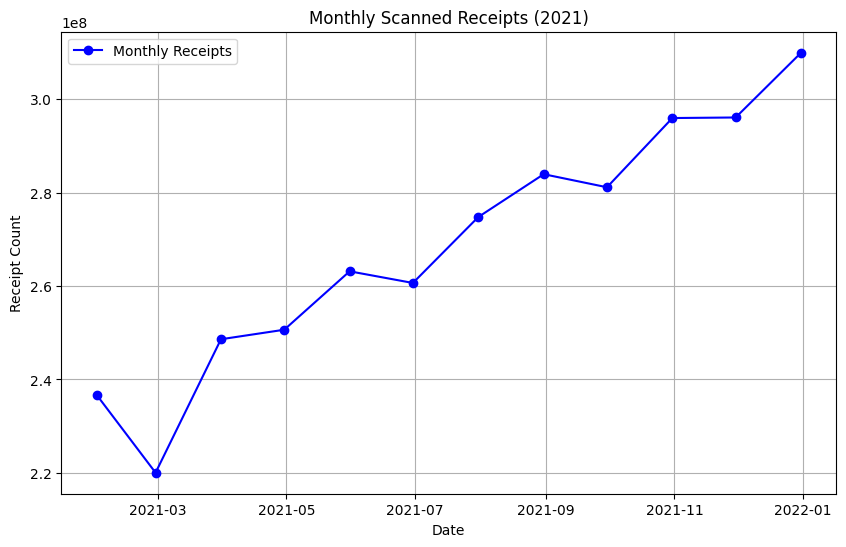

In [80]:
# Visualize the monthly receipt count
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, label='Monthly Receipts', marker='o', color='blue')
plt.title('Monthly Scanned Receipts (2021)')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.legend()
plt.show()


In [84]:
# Custom scaling functions
def custom_scale(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

def custom_inverse_scale(scaled_data, min_val, max_val):
    return scaled_data * (max_val - min_val) + min_val

# Scaling
min_val = monthly_data.min()
max_val = monthly_data.max()
scaled_data = custom_scale(monthly_data.values, min_val, max_val)

# Creating sequences for LSTM (look-back window of 3 months)
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 3  # Look-back window
X, y = create_sequences(scaled_data, seq_length)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors, reshaping to match the LSTM input
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add input size of 1
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Output should have shape [batch_size, 1]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)  # Same for test data
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [85]:
# Define LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        out = self.fc(lstm_out)
        return out

# Model hyperparameters
input_size = 1  # We are predicting based on 1 feature (receipt count)
hidden_size = 50
output_size = 1
num_layers = 1

# Initialize the model, define loss function and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [10/100], Loss: 0.1671
Epoch [20/100], Loss: 0.0903
Epoch [30/100], Loss: 0.0330
Epoch [40/100], Loss: 0.0203
Epoch [50/100], Loss: 0.0212
Epoch [60/100], Loss: 0.0177
Epoch [70/100], Loss: 0.0172
Epoch [80/100], Loss: 0.0158
Epoch [90/100], Loss: 0.0148
Epoch [100/100], Loss: 0.0136


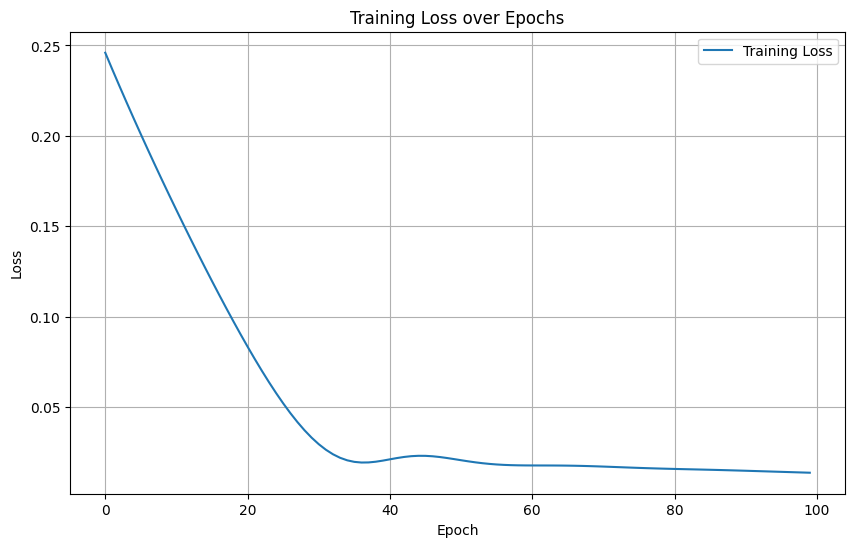

In [86]:
# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store and print loss every 10 epochs
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


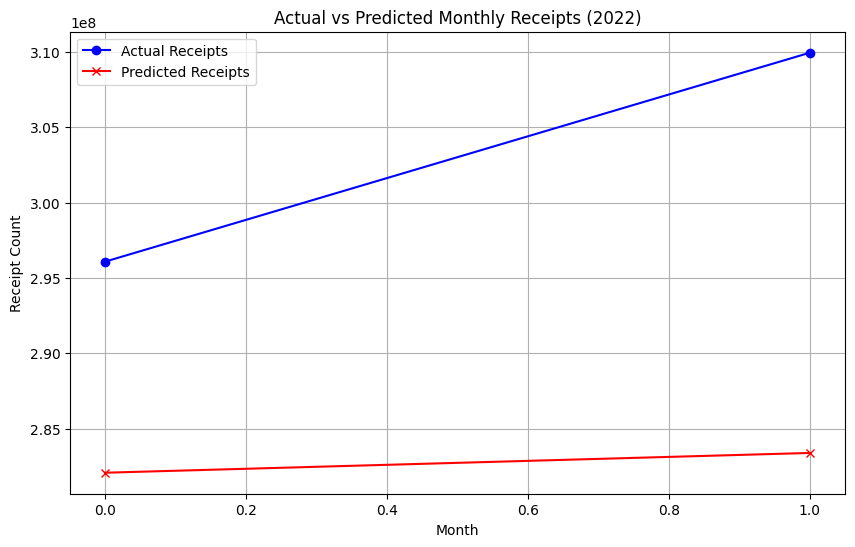

In [87]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Inverse scaling
predicted_receipts = custom_inverse_scale(predictions.numpy(), min_val, max_val)
actual_receipts = custom_inverse_scale(y_test_tensor.numpy(), min_val, max_val)

# Compare predicted vs actual
plt.figure(figsize=(10, 6))
plt.plot(actual_receipts, label='Actual Receipts', marker='o', color='blue')
plt.plot(predicted_receipts, label='Predicted Receipts', marker='x', color='red')
plt.title('Actual vs Predicted Monthly Receipts (2022)')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.legend()
plt.show()


/var/folders/9j/4qhm498x25s5m7dmvf5wny7m0000gn/T/ipykernel_87544/2739242464.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Receipt_Count'].resample('M').sum()


Training model with hidden_size=100, num_layers=1, learning_rate=0.001
Epoch [10/50], Loss: 0.166434, Val Loss: 0.580006
Epoch [20/50], Loss: 0.059458, Val Loss: 0.232250
Epoch [30/50], Loss: 0.011916, Val Loss: 0.049187
Epoch [40/50], Loss: 0.008866, Val Loss: 0.004568
Epoch [50/50], Loss: 0.009602, Val Loss: 0.003881
Training model with hidden_size=100, num_layers=1, learning_rate=0.0005
Epoch [10/50], Loss: 0.097081, Val Loss: 0.422725
Early stopping at epoch 10. Best validation loss: 0.002881
Training model with hidden_size=100, num_layers=2, learning_rate=0.001
Epoch [10/50], Loss: 0.104870, Val Loss: 0.389006
Early stopping at epoch 10. Best validation loss: 0.002881
Training model with hidden_size=100, num_layers=2, learning_rate=0.0005
Epoch [10/50], Loss: 0.137032, Val Loss: 0.546916
Early stopping at epoch 10. Best validation loss: 0.002881
Training model with hidden_size=500, num_layers=1, learning_rate=0.001
Epoch [10/50], Loss: 0.036718, Val Loss: 0.075472
Early stopping a

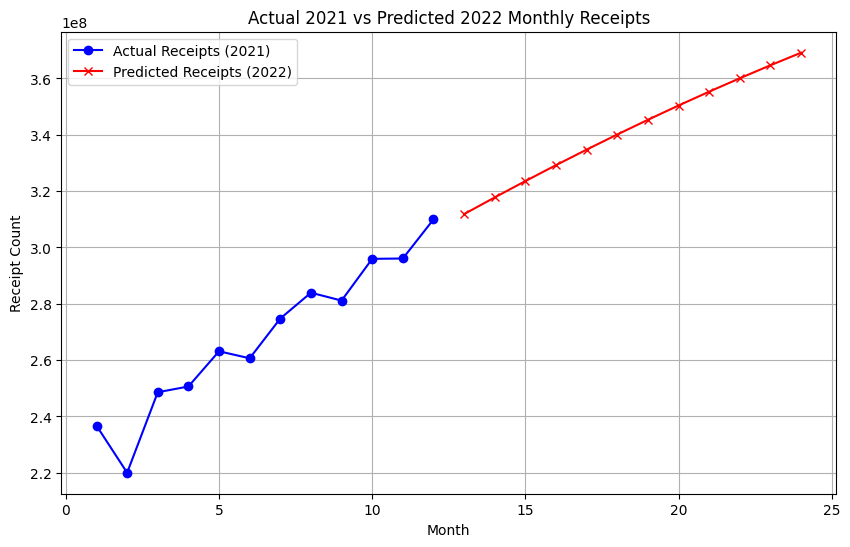

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product

# Load data
data = pd.read_csv('../data/data_daily.csv', parse_dates=['# Date'], index_col='# Date')
monthly_data = data['Receipt_Count'].resample('M').sum()

# Scale the data
min_val = monthly_data.min()
max_val = monthly_data.max()

def custom_scale(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

def custom_inverse_scale(scaled_data, min_val, max_val):
    return scaled_data * (max_val - min_val) + min_val

scaled_monthly_data = custom_scale(monthly_data.values, min_val, max_val)

# Prepare the dataset
X = np.array([[i] for i in range(1, len(scaled_monthly_data) + 1)])  # Month index
y = scaled_monthly_data

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X_train_tensor for LSTM [batch_size, time_step, input_size]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the sequence
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the target

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the sequence
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the target

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, x):
        # Initialize hidden state and cell state with the correct size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Hyperparameter grid
hidden_sizes = [100, 500, 1000]
num_layers_list = [1, 2]
learning_rates = [0.001, 0.0005]
epochs = 50
patience = 10  # Early stopping patience

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# For tracking the best model and best loss
best_val_loss = float('inf')
best_hyperparameters = None
best_model_path = 'best_model.pth'

# Grid search over hyperparameters
for hidden_size, num_layers, learning_rate in product(hidden_sizes, num_layers_list, learning_rates):
    print(f'Training model with hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}')
    
    # Initialize model and optimizer for each combination of hyperparameters
    model = LSTMModel(input_size=1, hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with validation and early stopping
    train_losses = []
    val_losses = []
    early_stop_count = 0

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            early_stop_count = 0
            best_hyperparameters = (hidden_size, num_layers, learning_rate)
            # Save the entire model
            torch.save(model, best_model_path)
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.6f}")
                break

# After grid search, load the best model
best_model = torch.load(best_model_path)

print(f"Best hyperparameters: hidden_size={best_hyperparameters[0]}, num_layers={best_hyperparameters[1]}, learning_rate={best_hyperparameters[2]}")

# Predict future months (for example, 2022)
with torch.no_grad():
    best_model.eval()
    future_months = np.array([[i] for i in range(len(monthly_data) + 1, len(monthly_data) + 13)])  # Predicting for 2022
    future_months_tensor = torch.tensor(future_months, dtype=torch.float32).unsqueeze(1).to(device)
    predicted_scaled_receipts = best_model(future_months_tensor).cpu().numpy()
    predicted_receipts = custom_inverse_scale(predicted_scaled_receipts, min_val, max_val)


# Visualization: Actual 2021 vs Predicted 2022
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(monthly_data)+1), monthly_data.values, label='Actual Receipts (2021)', marker='o', color='blue')
plt.plot(range(len(monthly_data)+1, len(monthly_data)+13), predicted_receipts, label='Predicted Receipts (2022)', marker='x', color='red')
plt.title('Actual 2021 vs Predicted 2022 Monthly Receipts')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.legend()
plt.show()
